### 1. Importing Required Libraries <br>
### 必要なライブラリのインポート

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


### 2. Loading and Preprocessing the Data
 ### データの読み込みと前処理


In [ ]:
df = pd.read_csv('stock_price.csv')

# Renaming columns for consistency
df.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Change_Rate']

# Converting 'Date' to datetime and sorting the data by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Convert 'Volume' to numeric (handling millions and billions)
def convert_volume(x):
    if isinstance(x, str):
        if 'M' in x:
            return float(x.replace('M', '')) * 1e6
        elif 'B' in x:
            return float(x.replace('B', '')) * 1e9
    return float(x)

df['Volume'] = df['Volume'].apply(convert_volume)

# Converting 'Change_Rate' from percentage to decimal
df['Change_Rate'] = df['Change_Rate'].str.rstrip('%').astype('float') / 100.0


### 3. Exploratory Data Analysis (EDA)
### 探索的データ分析（EDA）



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9202 entries, 1987-02-12 to 2024-08-01
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close        9202 non-null   float64
 1   Open         9202 non-null   float64
 2   High         9202 non-null   float64
 3   Low          9202 non-null   float64
 4   Volume       9202 non-null   float64
 5   Change_Rate  9202 non-null   float64
dtypes: float64(6)
memory usage: 503.2 KB
None
             Close         Open         High          Low        Volume  \
count  9202.000000  9202.000000  9202.000000  9202.000000  9.202000e+03   
mean     92.180961    92.256183    93.176451    91.330146  1.726677e+08   
std      50.452228    50.598215    51.049837    50.087405  1.251280e+08   
min      33.000000    33.000000    33.200000    32.200000  9.340000e+06   
25%      52.000000    52.100000    52.800000    51.500000  8.073000e+07   
50%      85.100000    85.100000    86.05000

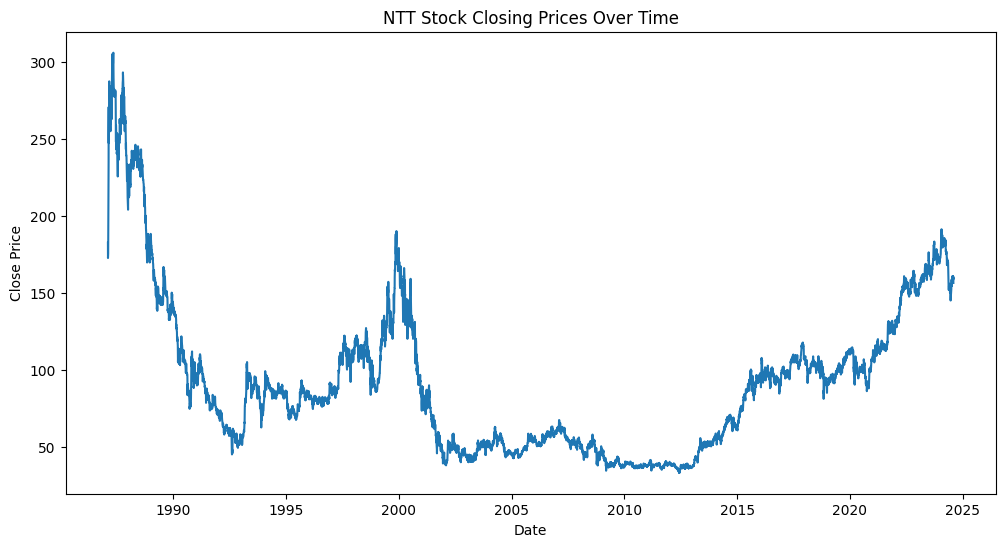

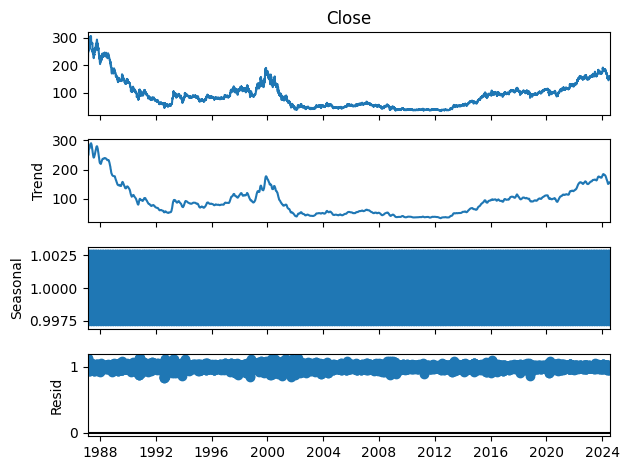

In [ ]:
# Displaying the basic information and summary of the dataset
print(df.info())
print(df.describe())

# Plotting the time series of 'Close' prices
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'])
plt.title('NTT Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Decomposing the series to observe trend and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='multiplicative', period=30)
result.plot()
plt.show()


### 4. Feature Engineering
### 特徴量エンジニアリング

In [ ]:
# Creating lag features and rolling statistics
df['Lag_1'] = df['Close'].shift(1)
df['Lag_7'] = df['Close'].shift(7)
df['Rolling_Mean_7'] = df['Close'].rolling(window=7).mean()
df['Rolling_Std_7'] = df['Close'].rolling(window=7).std()

# Dropping rows with missing values after creating lag features
df.dropna(inplace=True)


### 5. Data Normalization and Splitting
### データの正規化と分割

In [ ]:
# Initializing scalers for the features (X) and target (y)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Defining features and target variable
X = df[['Open', 'High', 'Low', 'Volume', 'Change_Rate', 'Lag_1', 'Lag_7', 'Rolling_Mean_7', 'Rolling_Std_7']]
y = df[['Close']]

# Scaling the features and target variable
X_scaled = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns, index=X.index)
y_scaled = pd.DataFrame(scaler_y.fit_transform(y), columns=y.columns, index=y.index)

# Splitting the data into training and test sets (no shuffling for time series)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Converting data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values)


### 6. Defining the Models
### モデルの定義

AR Model <br>
ARモデル

In [ ]:
class ARModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ARModel, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.hidden_layer(x))
        return self.output_layer(x)


LSTM Model <br>
LSTMモデル

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


Transformer Model <br>
ランスフォーマーモデル

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, nhead):
        super(TransformerModel, self).__init__()
        self.hidden_dim = (hidden_dim // nhead) * nhead
        self.input_projection = nn.Linear(input_dim, self.hidden_dim)
        self.positional_encoding = PositionalEncoding(self.hidden_dim, max_len=1000)
        encoder_layers = nn.TransformerEncoderLayer(d_model=self.hidden_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.output_projection = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_projection(x)
        x = x.permute(1, 0, 2)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x[-1]
        return self.output_projection(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]



### 7. Training Function
### トレーニング関数

In [ ]:
def train_model(model, X_train, y_train, epochs=100, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')


### 8. Evaluation Function
### 評価関数



In [ ]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
    predictions = predictions.numpy()
    y_test = y_test.numpy()

    predictions = scaler_y.inverse_transform(predictions)
    y_test = scaler_y.inverse_transform(y_test)

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}')

    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


### 9. Training and Evaluating Models
### モデルのトレーニングと評価

AR model <br>
ARモデル

Epoch 10/100, Loss: 0.0246
Epoch 20/100, Loss: 0.0118
Epoch 30/100, Loss: 0.0040
Epoch 40/100, Loss: 0.0007
Epoch 50/100, Loss: 0.0003
Epoch 60/100, Loss: 0.0003
Epoch 70/100, Loss: 0.0002
Epoch 80/100, Loss: 0.0001
Epoch 90/100, Loss: 0.0001
Epoch 100/100, Loss: 0.0001
MSE: 5.2256, MAE: 1.9039, R^2: 0.9935


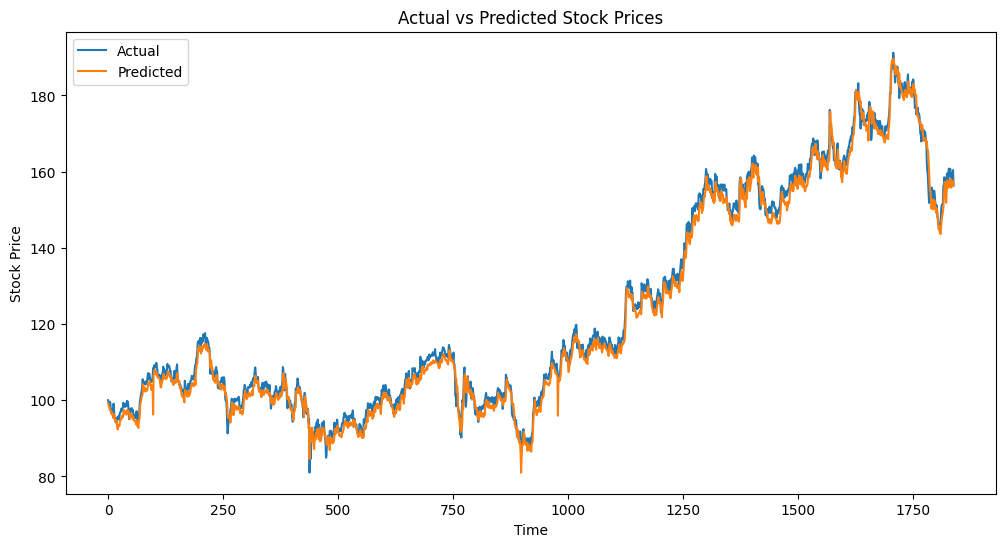

In [ ]:
ar_model = ARModel(input_dim=X_train_tensor.shape[1], hidden_dim=64, output_dim=1)
train_model(ar_model, X_train_tensor, y_train_tensor, epochs=100, lr=0.001)
evaluate_model(ar_model, X_test_tensor, y_test_tensor)


LSTM model <br>
LSTMモデル

Epoch 10/100, Loss: 0.0403
Epoch 20/100, Loss: 0.0310
Epoch 30/100, Loss: 0.0266
Epoch 40/100, Loss: 0.0184
Epoch 50/100, Loss: 0.0082
Epoch 60/100, Loss: 0.0010
Epoch 70/100, Loss: 0.0013
Epoch 80/100, Loss: 0.0006
Epoch 90/100, Loss: 0.0005
Epoch 100/100, Loss: 0.0004
MSE: 59.4498, MAE: 7.3500, R^2: 0.9261


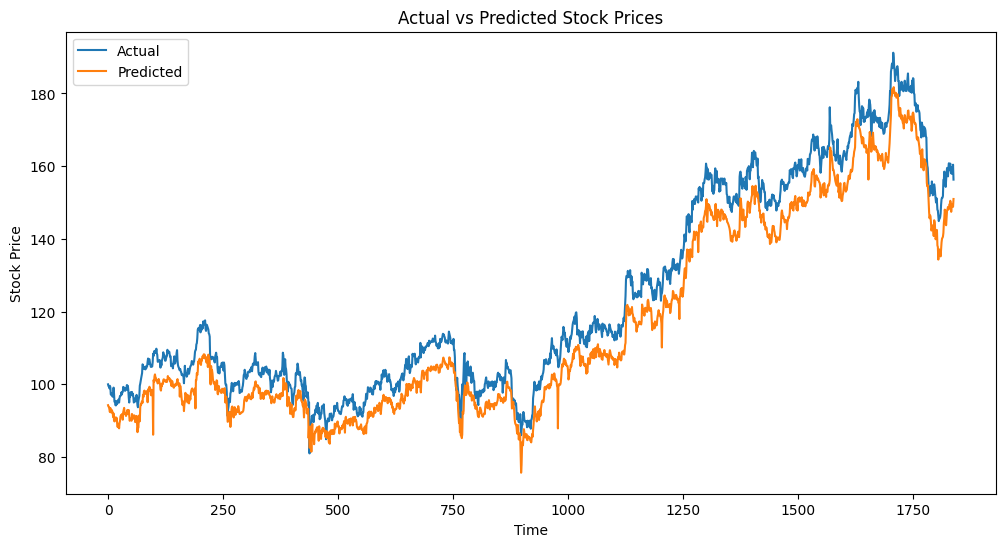

In [ ]:
lstm_model = LSTMModel(input_dim=X_train_tensor.shape[1], hidden_dim=64, output_dim=1, num_layers=2)
train_model(lstm_model, X_train_tensor.unsqueeze(1), y_train_tensor, epochs=100, lr=0.001)
evaluate_model(lstm_model, X_test_tensor.unsqueeze(1), y_test_tensor)

Transformer model <br>
ランスフォーマーモデル

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 10/100, Loss: 0.1415
Epoch 20/100, Loss: 0.0391
Epoch 30/100, Loss: 0.0388
Epoch 40/100, Loss: 0.0375
Epoch 50/100, Loss: 0.0259
Epoch 60/100, Loss: 0.0105
Epoch 80/100, Loss: 0.0083
Epoch 90/100, Loss: 0.0074
Epoch 100/100, Loss: 0.0071
MSE: 95.3577, MAE: 7.3383, R^2: 0.8815


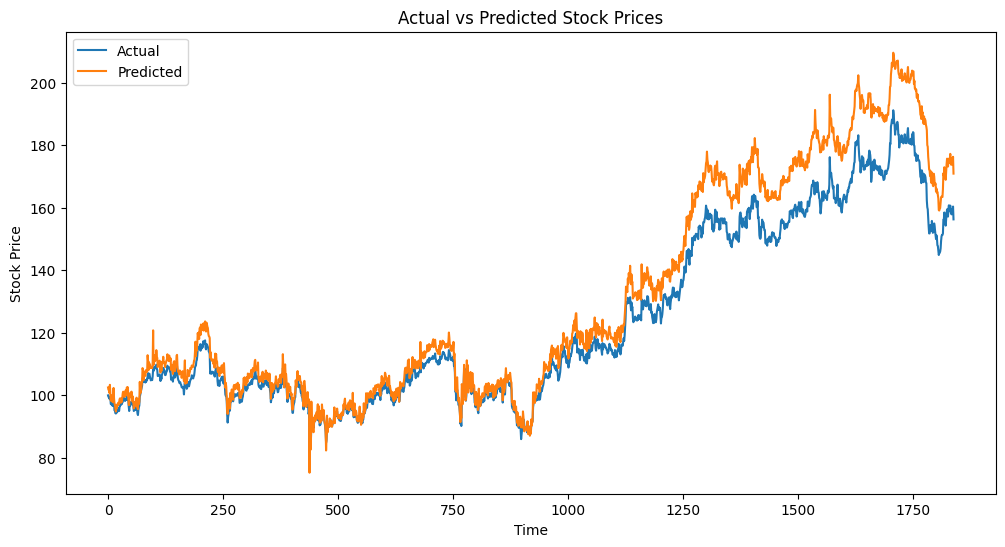

In [ ]:
transformer_model = TransformerModel(input_dim=X_train_tensor.shape[1], hidden_dim=64, output_dim=1, num_layers=2, nhead=8)
train_model(transformer_model, X_train_tensor.unsqueeze(1), y_train_tensor, epochs=100, lr=0.001)
evaluate_model(transformer_model, X_test_tensor.unsqueeze(1), y_test_tensor)

In [ ]:
pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 31.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=47cb2ac730e0a1df913559cc99ba97b7e2b4a4e99f4ac2f43be1bee9f960fa94
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


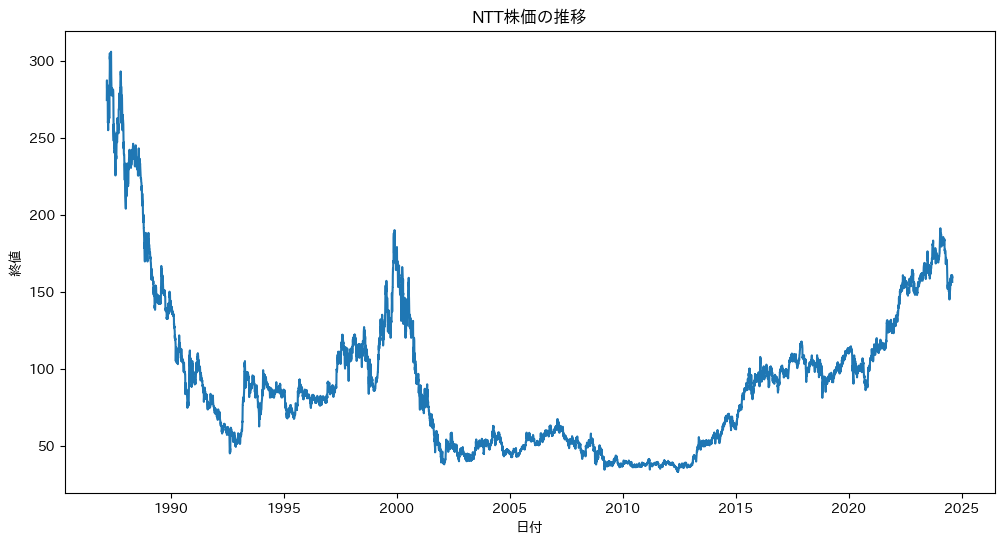

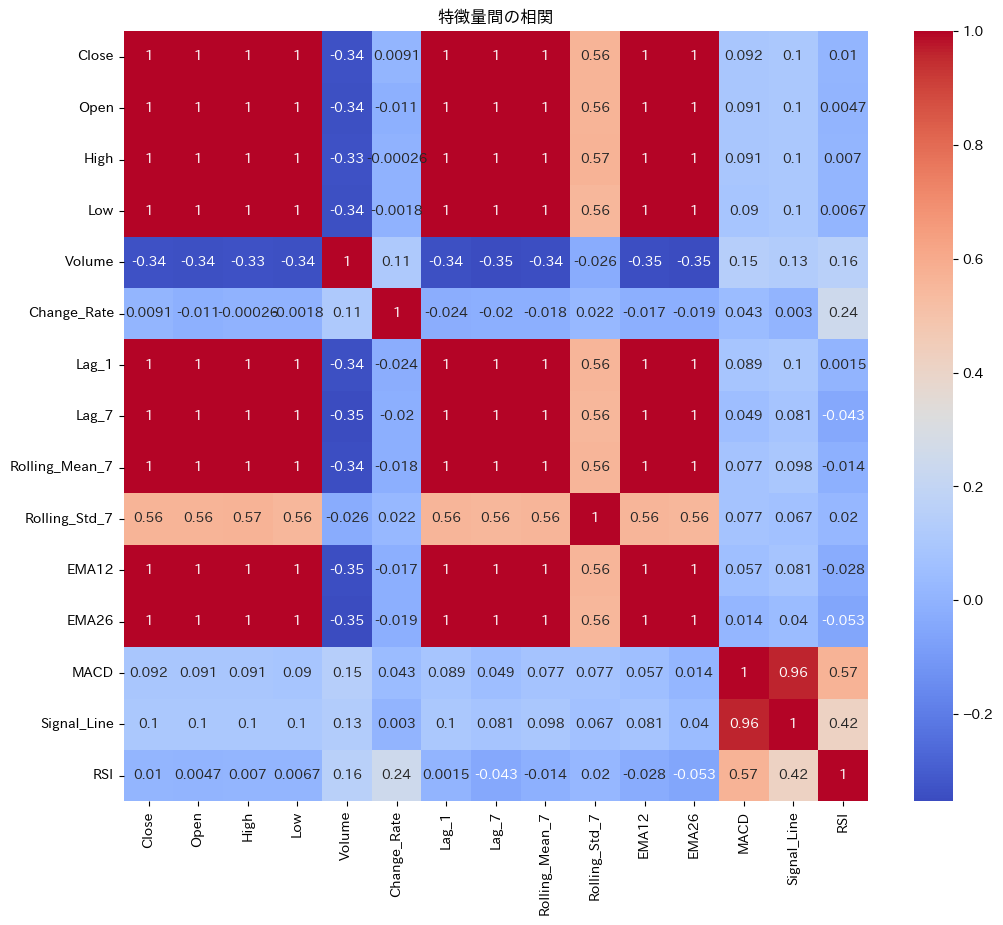

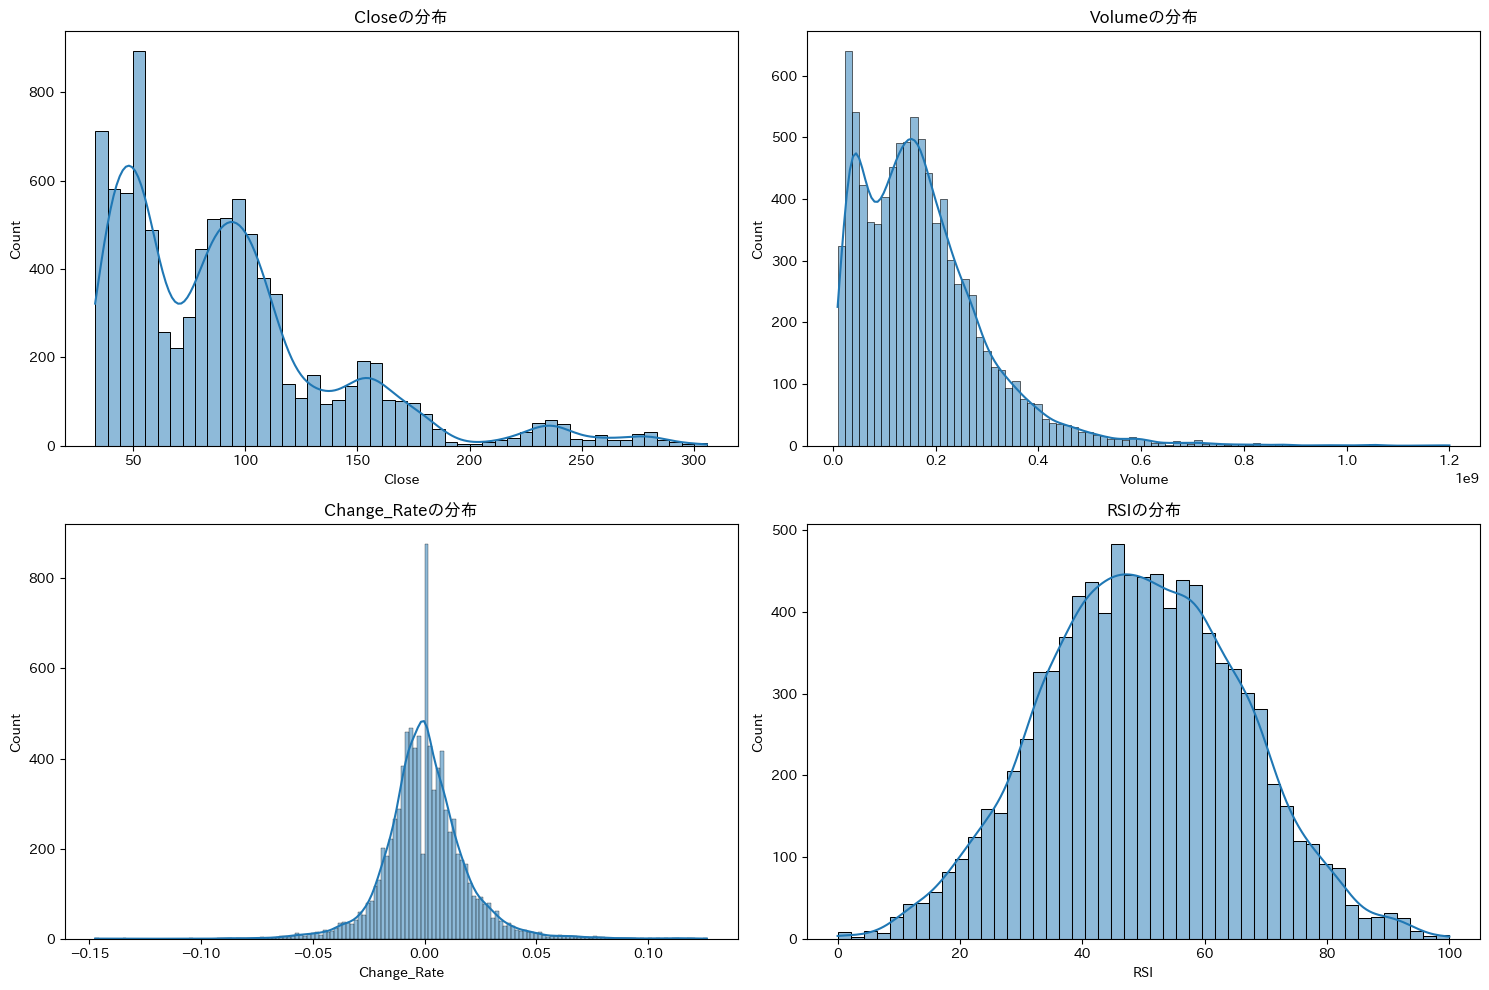

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


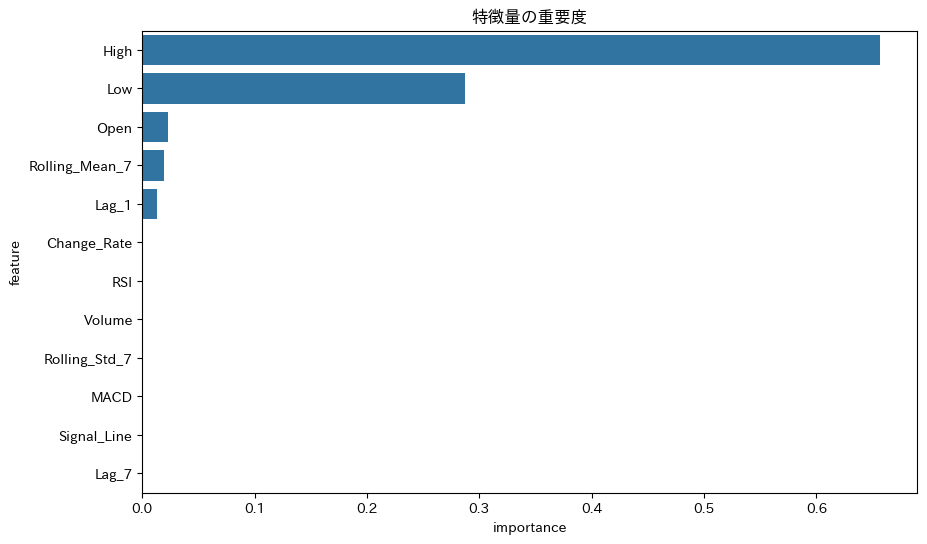

Epoch 10/50, Loss: 0.1172
Epoch 20/50, Loss: 0.0791
Epoch 30/50, Loss: 0.0498
Epoch 40/50, Loss: 0.0292
Epoch 50/50, Loss: 0.0176
Epoch 10/50, Loss: 0.0206
Epoch 20/50, Loss: 0.0020
Epoch 30/50, Loss: 0.0011
Epoch 40/50, Loss: 0.0002
Epoch 50/50, Loss: 0.0003
Epoch 10/50, Loss: 0.0069
Epoch 20/50, Loss: 0.0009
Epoch 30/50, Loss: 0.0016
Epoch 40/50, Loss: 0.0010
Epoch 50/50, Loss: 0.0005
Epoch 10/50, Loss: 0.0343
Epoch 20/50, Loss: 0.0323
Epoch 30/50, Loss: 0.0290
Epoch 40/50, Loss: 0.0236
Epoch 50/50, Loss: 0.0154
Epoch 10/50, Loss: 0.0022
Epoch 20/50, Loss: 0.0013
Epoch 30/50, Loss: 0.0003
Epoch 40/50, Loss: 0.0003
Epoch 50/50, Loss: 0.0002
Epoch 10/50, Loss: 0.0395
Epoch 20/50, Loss: 0.0058
Epoch 30/50, Loss: 0.0051
Epoch 40/50, Loss: 0.0024
Epoch 50/50, Loss: 0.0008
Epoch 10/50, Loss: 0.0729
Epoch 20/50, Loss: 0.0574
Epoch 30/50, Loss: 0.0433
Epoch 40/50, Loss: 0.0326
Epoch 50/50, Loss: 0.0299
Epoch 10/50, Loss: 0.0424
Epoch 20/50, Loss: 0.0258
Epoch 30/50, Loss: 0.0032
Epoch 40/50,

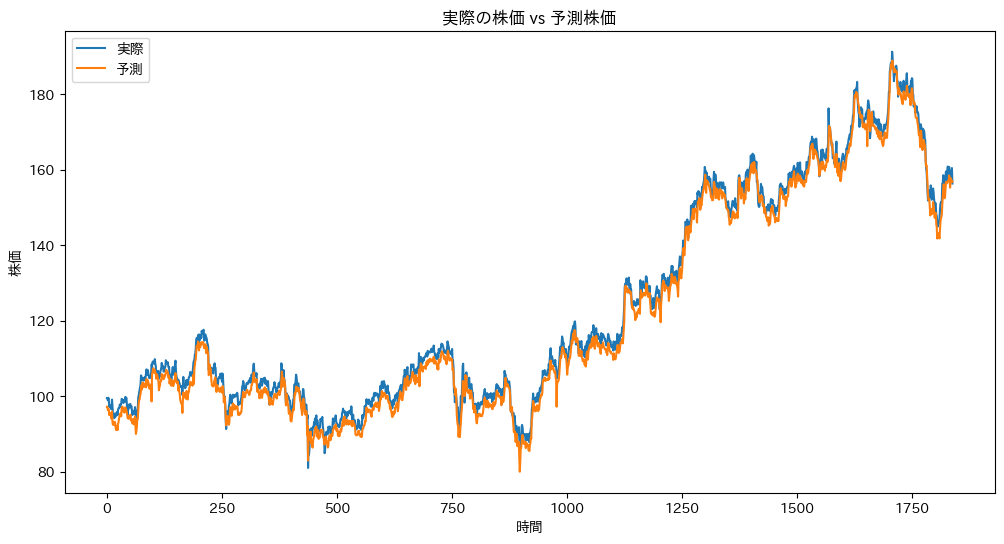

Epoch 10/100, Loss: 0.0460
Epoch 20/100, Loss: 0.0322
Epoch 30/100, Loss: 0.0268
Epoch 40/100, Loss: 0.0201
Epoch 50/100, Loss: 0.0111
Epoch 60/100, Loss: 0.0026
Epoch 70/100, Loss: 0.0010
Epoch 80/100, Loss: 0.0010
Epoch 90/100, Loss: 0.0006
Epoch 100/100, Loss: 0.0006
Epoch 10/100, Loss: 0.0617
Epoch 20/100, Loss: 0.0297
Epoch 30/100, Loss: 0.0226
Epoch 40/100, Loss: 0.0125
Epoch 50/100, Loss: 0.0029
Epoch 60/100, Loss: 0.0019
Epoch 70/100, Loss: 0.0011
Epoch 90/100, Loss: 0.0006
Epoch 100/100, Loss: 0.0004
Epoch 10/100, Loss: 0.0338
Epoch 20/100, Loss: 0.0294
Epoch 30/100, Loss: 0.0244
Epoch 40/100, Loss: 0.0189
Epoch 50/100, Loss: 0.0130
Epoch 60/100, Loss: 0.0074
Epoch 70/100, Loss: 0.0031
Epoch 80/100, Loss: 0.0009
Epoch 90/100, Loss: 0.0003
Epoch 100/100, Loss: 0.0003
アンサンブルモデルの評価結果:
MSE: 52.7049, MAE: 6.8450, R^2: 0.9345


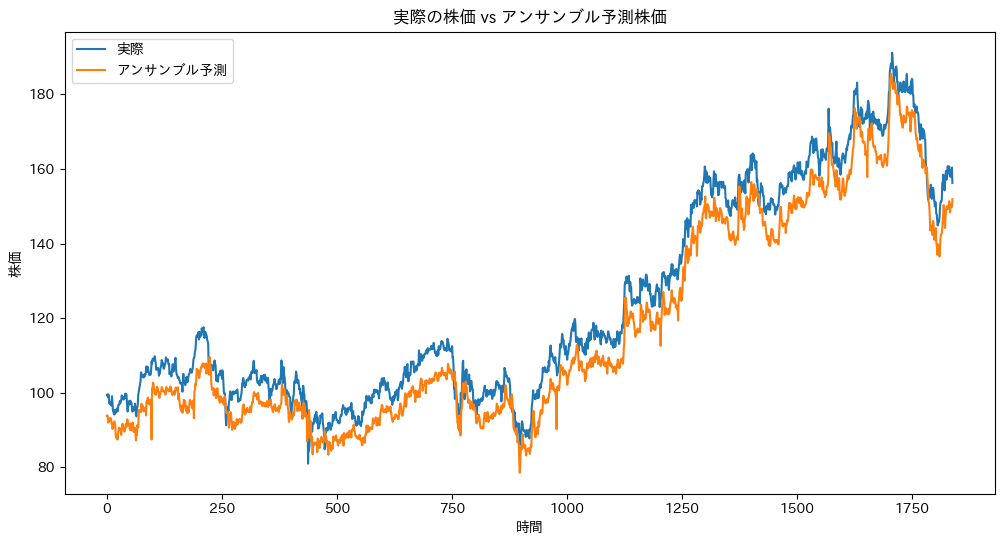

Epoch 10/50, Loss: 0.1593
Epoch 20/50, Loss: 0.0910
Epoch 30/50, Loss: 0.0284
Epoch 40/50, Loss: 0.0283
Epoch 50/50, Loss: 0.0185
Epoch 10/50, Loss: 0.2619
Epoch 20/50, Loss: 0.1694
Epoch 30/50, Loss: 0.0583
Epoch 40/50, Loss: 0.0176
Epoch 50/50, Loss: 0.0169
Epoch 10/50, Loss: 0.2306
Epoch 20/50, Loss: 0.1397
Epoch 30/50, Loss: 0.0414
Epoch 40/50, Loss: 0.0220
Epoch 50/50, Loss: 0.0153
Epoch 10/50, Loss: 0.2990
Epoch 20/50, Loss: 0.1937
Epoch 30/50, Loss: 0.0690
Epoch 40/50, Loss: 0.0152
Epoch 50/50, Loss: 0.0183
Epoch 10/50, Loss: 0.2100
Epoch 20/50, Loss: 0.1151
Epoch 30/50, Loss: 0.0248
Epoch 40/50, Loss: 0.0247
Epoch 50/50, Loss: 0.0129
Epoch 10/50, Loss: 0.1261
Epoch 20/50, Loss: 0.0720
Epoch 30/50, Loss: 0.0273
Epoch 40/50, Loss: 0.0253
Epoch 50/50, Loss: 0.0184
Epoch 10/50, Loss: 0.1178
Epoch 20/50, Loss: 0.0664
Epoch 30/50, Loss: 0.0237
Epoch 40/50, Loss: 0.0246
Epoch 50/50, Loss: 0.0162
Epoch 10/50, Loss: 0.0880
Epoch 20/50, Loss: 0.0490
Epoch 30/50, Loss: 0.0256
Epoch 40/50,

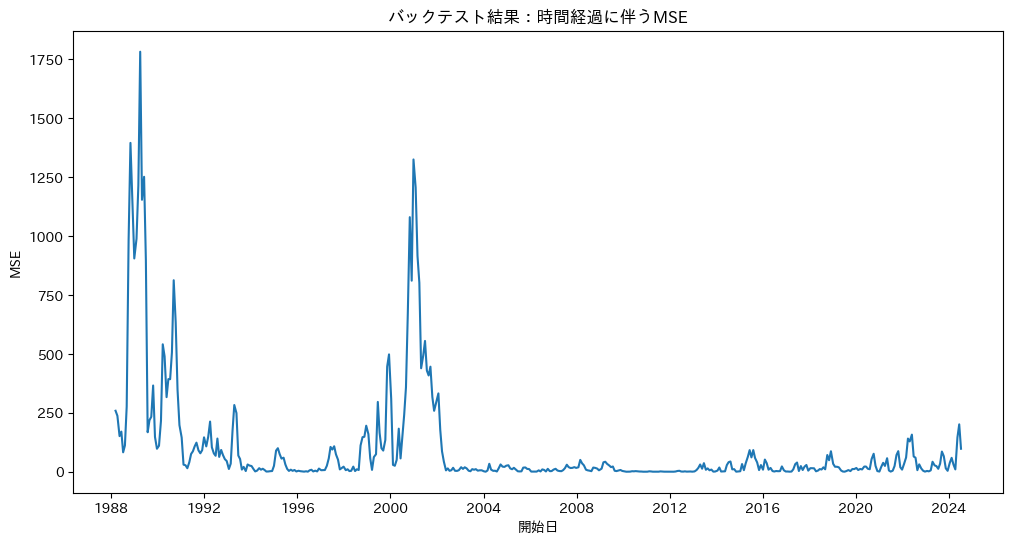

株価予測モデルの構築と評価が完了しました。
クロスバリデーションの実行:
Epoch 10/50, Loss: 0.1455
Epoch 20/50, Loss: 0.0927
Epoch 30/50, Loss: 0.0435
Epoch 40/50, Loss: 0.0364
Epoch 50/50, Loss: 0.0242
Epoch 10/50, Loss: 0.0126
Epoch 20/50, Loss: 0.0046
Epoch 30/50, Loss: 0.0008
Epoch 40/50, Loss: 0.0009
Epoch 50/50, Loss: 0.0007
Epoch 10/50, Loss: 0.0005
Epoch 20/50, Loss: 0.0003
Epoch 30/50, Loss: 0.0001
Epoch 40/50, Loss: 0.0001
Epoch 50/50, Loss: 0.0000
Epoch 10/50, Loss: 0.0002
Epoch 20/50, Loss: 0.0001
Epoch 30/50, Loss: 0.0000
Epoch 40/50, Loss: 0.0000
Epoch 50/50, Loss: 0.0000
Epoch 10/50, Loss: 0.0001
Epoch 20/50, Loss: 0.0000
Epoch 30/50, Loss: 0.0000
Epoch 40/50, Loss: 0.0000
Epoch 50/50, Loss: 0.0000
Cross-validation MSE scores: [0.02411642162321229, 0.000962082177171112, 3.6389015906470185e-05, 2.1781025890088454e-05, 3.551136720093542e-05]
Average MSE: 0.0050


In [ ]:
# -*- coding: utf-8 -*-
"""
Improved Stock Price Prediction Model
改良版株価予測モデル
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import japanize_matplotlib

# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import japanize_matplotlib

# データの読み込みと前処理
# データの読み込みと前処理
def load_and_preprocess_data(file_path):
    df = pd.read_csv('/content/stock_price.csv')
    df.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Change_Rate']
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)

    # ボリュームの変換（単位：百万株、十億株）
    df['Volume'] = df['Volume'].apply(lambda x: float(x.replace('M', '')) * 1e6 if 'M' in str(x) else (float(x.replace('B', '')) * 1e9 if 'B' in str(x) else float(x)))

    # 変化率をパーセンテージから小数に変換
    df['Change_Rate'] = df['Change_Rate'].str.rstrip('%').astype('float') / 100.0

    return df

# 特徴量エンジニアリング
def engineer_features(df):
    # ラグ特徴量と移動平均の作成
    df['Lag_1'] = df['Close'].shift(1)
    df['Lag_7'] = df['Close'].shift(7)
    df['Rolling_Mean_7'] = df['Close'].rolling(window=7).mean()
    df['Rolling_Std_7'] = df['Close'].rolling(window=7).std()

    # 技術的指標の追加
    # MACD (Moving Average Convergence Divergence)
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # 欠損値の削除
    df.dropna(inplace=True)

    return df

# 探索的データ分析 (EDA)
def perform_eda(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'])
    plt.title('NTT株価の推移')
    plt.xlabel('日付')
    plt.ylabel('終値')
    plt.show()

    # 相関ヒートマップ
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title('特徴量間の相関')
    plt.show()

    # 分布プロット
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(['Close', 'Volume', 'Change_Rate', 'RSI']):
        plt.subplot(2, 2, i+1)
        sns.histplot(df[col], kde=True)
        plt.title(f'{col}の分布')
    plt.tight_layout()
    plt.show()

# 特徴量重要度の分析
def analyze_feature_importance(X, y):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('特徴量の重要度')
    plt.show()

    return feature_importance

# モデルの定義
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# モデルの訓練
def train_model(model, X_train, y_train, epochs=100, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# モデルの評価
def evaluate_model(model, X_test, y_test, scaler_y):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
    predictions = predictions.numpy()
    y_test = y_test.numpy()

    predictions = scaler_y.inverse_transform(predictions)
    y_test = scaler_y.inverse_transform(y_test)

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}')

    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='実際')
    plt.plot(predictions, label='予測')
    plt.title('実際の株価 vs 予測株価')
    plt.xlabel('時間')
    plt.ylabel('株価')
    plt.legend()
    plt.show()

# ハイパーパラメータチューニング
def tune_hyperparameters(X_train, y_train):
    param_grid = {
        'hidden_dim': [32, 64, 128],
        'num_layers': [1, 2, 3],
        'lr': [0.001, 0.01, 0.1]
    }

    def create_model(hidden_dim, num_layers, lr):
        model = LSTMModel(input_dim=X_train.shape[2], hidden_dim=hidden_dim, output_dim=1, num_layers=num_layers)
        return model

    best_mse = float('inf')
    best_params = None

    for hidden_dim in param_grid['hidden_dim']:
        for num_layers in param_grid['num_layers']:
            for lr in param_grid['lr']:
                model = create_model(hidden_dim, num_layers, lr)
                train_model(model, X_train, y_train, epochs=50, lr=lr)

                model.eval()
                with torch.no_grad():
                    predictions = model(X_train)
                mse = mean_squared_error(y_train.numpy(), predictions.numpy())

                if mse < best_mse:
                    best_mse = mse
                    best_params = {'hidden_dim': hidden_dim, 'num_layers': num_layers, 'lr': lr}

    print(f"Best parameters: {best_params}")
    return best_params

# アンサンブル手法
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        predictions = [model(X).detach().numpy() for model in self.models]
        return np.mean(predictions, axis=0)

# バックテスト
def perform_backtesting(df, window_size=252, step=20):
    results = []
    for i in range(0, len(df) - window_size, step):
        train = df.iloc[i:i+window_size]
        test = df.iloc[i+window_size:i+window_size+step]

        X_train = train[['Open', 'High', 'Low', 'Volume', 'Change_Rate', 'Lag_1', 'Lag_7', 'Rolling_Mean_7', 'Rolling_Std_7', 'MACD', 'Signal_Line', 'RSI']]
        y_train = train[['Close']]
        X_test = test[['Open', 'High', 'Low', 'Volume', 'Change_Rate', 'Lag_1', 'Lag_7', 'Rolling_Mean_7', 'Rolling_Std_7', 'MACD', 'Signal_Line', 'RSI']]
        y_test = test[['Close']]

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train)
        X_test_scaled = scaler_X.transform(X_test)

        X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(1)
        y_train_tensor = torch.FloatTensor(y_train_scaled)
        X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(1)

        model = LSTMModel(input_dim=X_train_tensor.shape[2], hidden_dim=64, output_dim=1, num_layers=2)
        train_model(model, X_train_tensor, y_train_tensor, epochs=50)

        model.eval()
        with torch.no_grad():
            predictions = model(X_test_tensor)
        predictions = scaler_y.inverse_transform(predictions.numpy())

        mse = mean_squared_error(y_test, predictions)
        results.append({'start_date': test.index[0], 'mse': mse})

    results_df = pd.DataFrame(results)
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['start_date'], results_df['mse'])
    plt.title('バックテスト結果：時間経過に伴うMSE')
    plt.xlabel('開始日')
    plt.ylabel('MSE')
    plt.show()

# メイン実行部分
if __name__ == "__main__":
    # データの読み込みと前処理
    df = load_and_preprocess_data('stock_price.csv')
    df = engineer_features(df)

    # 探索的データ分析 (EDA)
    perform_eda(df)

    # 特徴量と目標変数の定義
    X = df[['Open', 'High', 'Low', 'Volume', 'Change_Rate', 'Lag_1', 'Lag_7', 'Rolling_Mean_7', 'Rolling_Std_7', 'MACD', 'Signal_Line', 'RSI']]
    y = df[['Close']]

    # 特徴量重要度の分析
    feature_importance = analyze_feature_importance(X, y)

    # データの正規化
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # データの分割
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

    # PyTorchテンソルへの変換
    X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1)
    y_test_tensor = torch.FloatTensor(y_test)

    # ハイパーパラメータチューニング
    best_params = tune_hyperparameters(X_train_tensor, y_train_tensor)

    # 最適なモデルの訓練
    best_model = LSTMModel(input_dim=X_train_tensor.shape[2], hidden_dim=best_params['hidden_dim'], output_dim=1, num_layers=best_params['num_layers'])
    train_model(best_model, X_train_tensor, y_train_tensor, epochs=100, lr=best_params['lr'])

    # モデルの評価
    evaluate_model(best_model, X_test_tensor, y_test_tensor, scaler_y)

    # アンサンブルモデルの作成と評価
    models = [
        LSTMModel(input_dim=X_train_tensor.shape[2], hidden_dim=64, output_dim=1, num_layers=2),
        LSTMModel(input_dim=X_train_tensor.shape[2], hidden_dim=128, output_dim=1, num_layers=3),
        LSTMModel(input_dim=X_train_tensor.shape[2], hidden_dim=32, output_dim=1, num_layers=1)
    ]

    for model in models:
        train_model(model, X_train_tensor, y_train_tensor, epochs=100)

    ensemble_model = EnsembleModel(models)
    ensemble_predictions = ensemble_model.predict(X_test_tensor)
    ensemble_predictions = scaler_y.inverse_transform(ensemble_predictions)
    y_test_inv = scaler_y.inverse_transform(y_test)

    print("アンサンブルモデルの評価結果:")
    mse = mean_squared_error(y_test_inv, ensemble_predictions)
    mae = mean_absolute_error(y_test_inv, ensemble_predictions)
    r2 = r2_score(y_test_inv, ensemble_predictions)
    print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}')

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inv, label='実際')
    plt.plot(ensemble_predictions, label='アンサンブル予測')
    plt.title('実際の株価 vs アンサンブル予測株価')
    plt.xlabel('時間')
    plt.ylabel('株価')
    plt.legend()
    plt.show()

    # バックテストの実行
    perform_backtesting(df)

    print("株価予測モデルの構築と評価が完了しました。")

# クロスバリデーション関数
def perform_cross_validation(X, y, model, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_scores = []

    for train_index, val_index in tscv.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)
        y_train_tensor = torch.FloatTensor(y_train)
        X_val_tensor = torch.FloatTensor(X_val).unsqueeze(1)
        y_val_tensor = torch.FloatTensor(y_val)

        train_model(model, X_train_tensor, y_train_tensor, epochs=50)

        model.eval()
        with torch.no_grad():
            predictions = model(X_val_tensor)
        mse = mean_squared_error(y_val, predictions.numpy())
        cv_scores.append(mse)

    print(f"Cross-validation MSE scores: {cv_scores}")
    print(f"Average MSE: {np.mean(cv_scores):.4f}")

# クロスバリデーションの実行
print("クロスバリデーションの実行:")
cv_model = LSTMModel(input_dim=X_train_tensor.shape[2], hidden_dim=64, output_dim=1, num_layers=2)
perform_cross_validation(X_scaled, y_scaled, cv_model)